In [163]:
import pennylane as qml
from pennylane import numpy as np
import pickle
import matplotlib.pyplot as plt

In [91]:
with open('alphabet_w.pickle', 'rb') as alphabet:
    alphabet = pickle.load(alphabet)

In [92]:
alphabet

{'0': {'gate': pennylane.ops.qubit.PauliX, 'wires': [2]},
 '1': {'gate': pennylane.ops.qubit.RZ,
  'wires': [0],
  'params': [3.141592653589793]},
 '2': {'gate': pennylane.ops.qubit.RY,
  'wires': [1],
  'params': [1.9100883333825942]},
 '3': {'gate': pennylane.ops.qubit.CNOT, 'wires': [1, 2]},
 '4': {'gate': pennylane.ops.qubit.CNOT, 'wires': [1, 0]},
 '5': {'gate': pennylane.ops.qubit.RY, 'wires': [0], 'params': [0.78476]},
 '6': {'gate': pennylane.ops.qubit.Rot,
  'wires': [0],
  'params': array([-2.31419177e-03,  5.49757776e+00,  3.14314062e+00])},
 '7': {'gate': pennylane.ops.qubit.CNOT, 'wires': [0, 1]}}

In [146]:
def return_list_pars(route):
    #route specifies the gates to append. This function is to be able to compute the gradient
    ind_par=0
    p=[]
    for k in route:
        if "params" in alphabet[str(k)].keys():
            p.append(qml.variable.Variable(idx=ind_par))
            ind_par+=1
    return p

In [165]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def circuit(params,route):
    ind_par=0
    for k in route:
        operation = alphabet[str(int(k.val))]
        if "params" in operation.keys():
            if operation["gate"].num_params == 1:
                operation["gate"](params[ind_par], wires = operation["wires"])
                ind_par+=1
            else:
                operation["gate"](params[ind_par],params[ind_par+1],params[ind_par+2], wires = operation["wires"])
                ind_par+=3
        else:
            operation["gate"](wires = operation["wires"])
    return qml.expval(qml.PauliZ(1))

In [168]:
route = [2]
params = return_list_pars(route)
circuit(np.random.sample(len(params)),route)
qgrad = qml.grad(circuit, argnum=0)
g=[]
for val in np.arange(-np.pi,np.pi,.01):
    g.append(qgrad([val],route)[0])

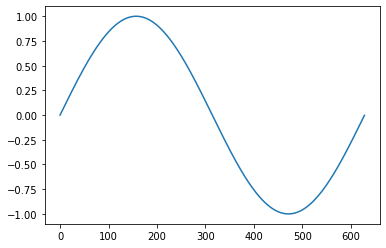

In [169]:
plt.plot(g)

Now let's translate this into the W-state preparation:

In [180]:
import numpy as np
import pennylane as qml
import pickle


def projector(ket):
    ket = np.expand_dims(ket, 1)
    proj = ket.dot(ket.conjugate().T)
    return proj

n_qubits=3
dev = qml.device("default.qubit", wires=n_qubits)

with open('alphabet_w.pickle', 'rb') as alphabet:
    alphabet = pickle.load(alphabet)


sq = 1 / np.sqrt(3)
w_state = np.array([0, sq, sq, 0, sq, 0, 0, 0])
observable = qml.Hermitian(projector(w_state), wires=[0, 1, 2])



In [193]:
def return_list_pars(route):
    #route specifies the gates to append. This function is to be able to compute the gradient.
    #The gates we use are qml.Rot (3 free parameters), or RX, RY, RZ (only one free param).
    #optimal_route for W-state = [0,1,2,3,4,5,4,6,7] 
    ind_par=0
    p=[]
    for k in route:
        operation = alphabet[str(k)]
        if "params" in operation.keys():
            if operation["gate"].num_params == 1:
                p.append(qml.variable.Variable(idx=ind_par))
                ind_par+=1
            else:
                for ind1 in range(3):
                    p.append(qml.variable.Variable(idx=ind_par+ind1))
                ind_par+=3
    return p

In [181]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def circuit_energy(params,route):
    ind_par=0
    for k in route:
        operation = alphabet[str(int(k.val))]
        if "params" in operation.keys():
            if operation["gate"].num_params == 1:
                operation["gate"](params[ind_par], wires = operation["wires"])
                ind_par+=1
            else:
                operation["gate"](params[ind_par],params[ind_par+1],params[ind_par+2], wires = operation["wires"])
                ind_par+=3
        else:
            operation["gate"](wires = operation["wires"])
    return qml.expval(qml.Hermitian(projector(w_state), wires=[0, 1, 2]))

pars = return_list_pars(route)
circuit(np.random.sample(len(pars)), route)
#qgrad = qml.grad(circuit, argnum=0)
#qgrad(np.random.sample(len(opt_pars)), optimal_route)

def loss(x):
    return 1-circuit_energy(x, optimal_route)

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = np.random.sample(len(opt_pars))

for i in range(steps):
    params = opt.step(loss, params)
energy = circuit_energy()

In [199]:
route = [0]
pars = return_list_pars(route)
circuit([], route)

0.3333333333333334

In [191]:
circuit(params, optimal_route)

0.9969111372977922

In [ ]:
def run_state(list_ops):

    @qml.qnode(device=dev)
    def circuit_probs():
        circuit()
        return qml.probs(wires=list(range(n_qubits)))

    @qml.qnode(device=dev)
    def circuit_obs():
        circuit()
        return qml.expval(observable)

    energy = circuit_obs()
    probs = circuit_probs()
    print(qml.grad(circuit_obs, argnum=0))
    return energy, probs
